<center>
    <img src="./images/Sentiments.png" height="150" width="412" alt="sentiments"><br>
    <h1 style="color: DeepSkyBlue;font-family:verdana"><b>Twitter Sentiment Analysis</b></h1>
    <h3 style="color: DeepSkyBlue;font-family:courier"><i>Interpreting and Classifying Sentiments</i></h3>
</center>

<hr>

<p><strong>Author:</strong> Soumyadeep Ghosh</p>
<p><strong>Date:</strong> May, 2024</p>
<p>Welcome to the project! Below you will find more details.</p>

<hr>

<h2 style="color: DeepSkyBlue;">Table of contents</h2>

1. [Introduction](#p1)
2. [Importing dependencies](#p2)
3. [Importing dataset](#p3)
4. [Exploratory Data Analysis](#p4)
5. [Data Preprocessing](#p5)
6. [Word Cloud](#p6)
7. [Splitting data](#p7)
8. [TF-IDF Vectoriser](#p8)
9. [Creating and Evaluating Models](#p9)
    * [Logistic Regression Model](#p9-1)
    * [BernoulliNB Model](#p9-2)
    * [LinearSVC Model](#p9-3)
10. [Test on custom tweets](#p10)

<br>
<hr>

<a id="p1"></a>
<center><font color='PaleVioletRed' size='6'><i>Introduction</i></font></center>

* **Natural Language Processing (NLP):** NLP, or Natural Language Processing, combines computer science, AI, and linguistics to help computers understand and interact with human language. It's behind tasks like language translation, sentiment analysis, and speech recognition, making possible applications like virtual assistants and search engines. NLP is constantly evolving, driving advancements in various fields by enabling more natural communication between humans and machines.

* **Sentiment Analysis:** Sentiment Analysis involves analyzing text data to interpret and classify emotions as positive, negative, or neutral. It helps organizations understand public sentiment towards specific words or topics. By employing text analysis techniques, sentiment analysis enables businesses to gauge public opinion, allowing for informed decision-making and targeted actions.

The task of this project is to develop a <u>Sentiment Analysis model</u> to categorize a tweet as ***Positive*** or ***Negative***.

<a id="p2"></a>
<center><font color='PaleVioletRed' size='6'><i>Importing Dependencies</i></font></center>

In [1]:
# basic utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from dateutil import parser
from IPython.display import Image, HTML, display
import time

# scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

# nltk-nlp
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# emoji
from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS

# Ignore all
import warnings
warnings.filterwarnings(action = 'ignore')

<a id="p3"></a>
<center><font color='PaleVioletRed' size='6'><i>Importing Dataset</i></font></center>

The dataset being used is the **sentiment140 dataset**. It contains 1,600,000 tweets extracted using the **Twitter API**. The tweets have been annotated **(0 = Negative, 4 = Positive)** and they can be used to detect sentiment.
 
*[The training data isn't perfectly categorised as it has been created by tagging the text according to the emoji present. So, any model built using this dataset may have lower than expected accuracy, since the dataset isn't perfectly categorised.]*

**It contains the following 6 fields:**
1. **sentiment**: the polarity of the tweet *(0 = negative, 4 = positive)*
2. **ids**: The id of the tweet *(2087)*
3. **date**: the date of the tweet *(Sat May 16 23:58:44 UTC 2009)*
4. **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
5. **user**: the user that tweeted *(robotickilldozr)*
6. **text**: the text of the tweet *(Lyx is cool)*

In [2]:
df = pd.read_csv("data/twitter 1.6million tweets.csv",
                 encoding="ISO-8859-1",
                 names=["sentiment", "ids", "date", "flag", "user", "text"])

# Parse the date column using dateutil.parser.parse
df['date'] = df['date'].apply(parser.parse)

df["sentiment"] = df["sentiment"].replace({0: "Negative", 4: "Positive"})

- Check out [dateutil.parser.parse](https://dateutil.readthedocs.io/en/stable/parser.html). I am using this for the first time and found it to be really helpful!

<a id="p4"></a>
<center><font color='PaleVioletRed' size='6'><i>Exploratory Data Analysis</i></font></center>

In [3]:
df.head()

,sentiment,ids,date,flag,user,text
0,Negative,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.columns

Index(['sentiment', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   sentiment  1600000 non-null  object        
 1   ids        1600000 non-null  int64         
 2   date       1600000 non-null  datetime64[ns]
 3   flag       1600000 non-null  object        
 4   user       1600000 non-null  object        
 5   text       1600000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 73.2+ MB


Checking for `missing` values

In [6]:
df.isna().sum()

sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64

Checking for `duplicate` rows

In [7]:
df.duplicated().sum()

0

Collecting basic info

In [8]:
print(f"Total number of unique tweets are {len(df["ids"].unique())}.")
print(f"The period of available data: From {df['date'].dt.to_period('d').min()} to {df['date'].dt.to_period('d').max()}.")
print(f"The number of unique users are {len(df['user'].unique())}.")
print(f"The types flags used: {(", ").join(df['flag'].unique())}.")
print(f"Sentiment types: {(", ").join(map(str, df['sentiment'].unique()))}.")

Total number of unique tweets are 1598315.
The period of available data: From 2009-04-06 to 2009-06-25.
The number of unique users are 659775.
The types flags used: NO_QUERY.
Sentiment types: Negative, Positive.


#### Analyzing the distribution of sentiments

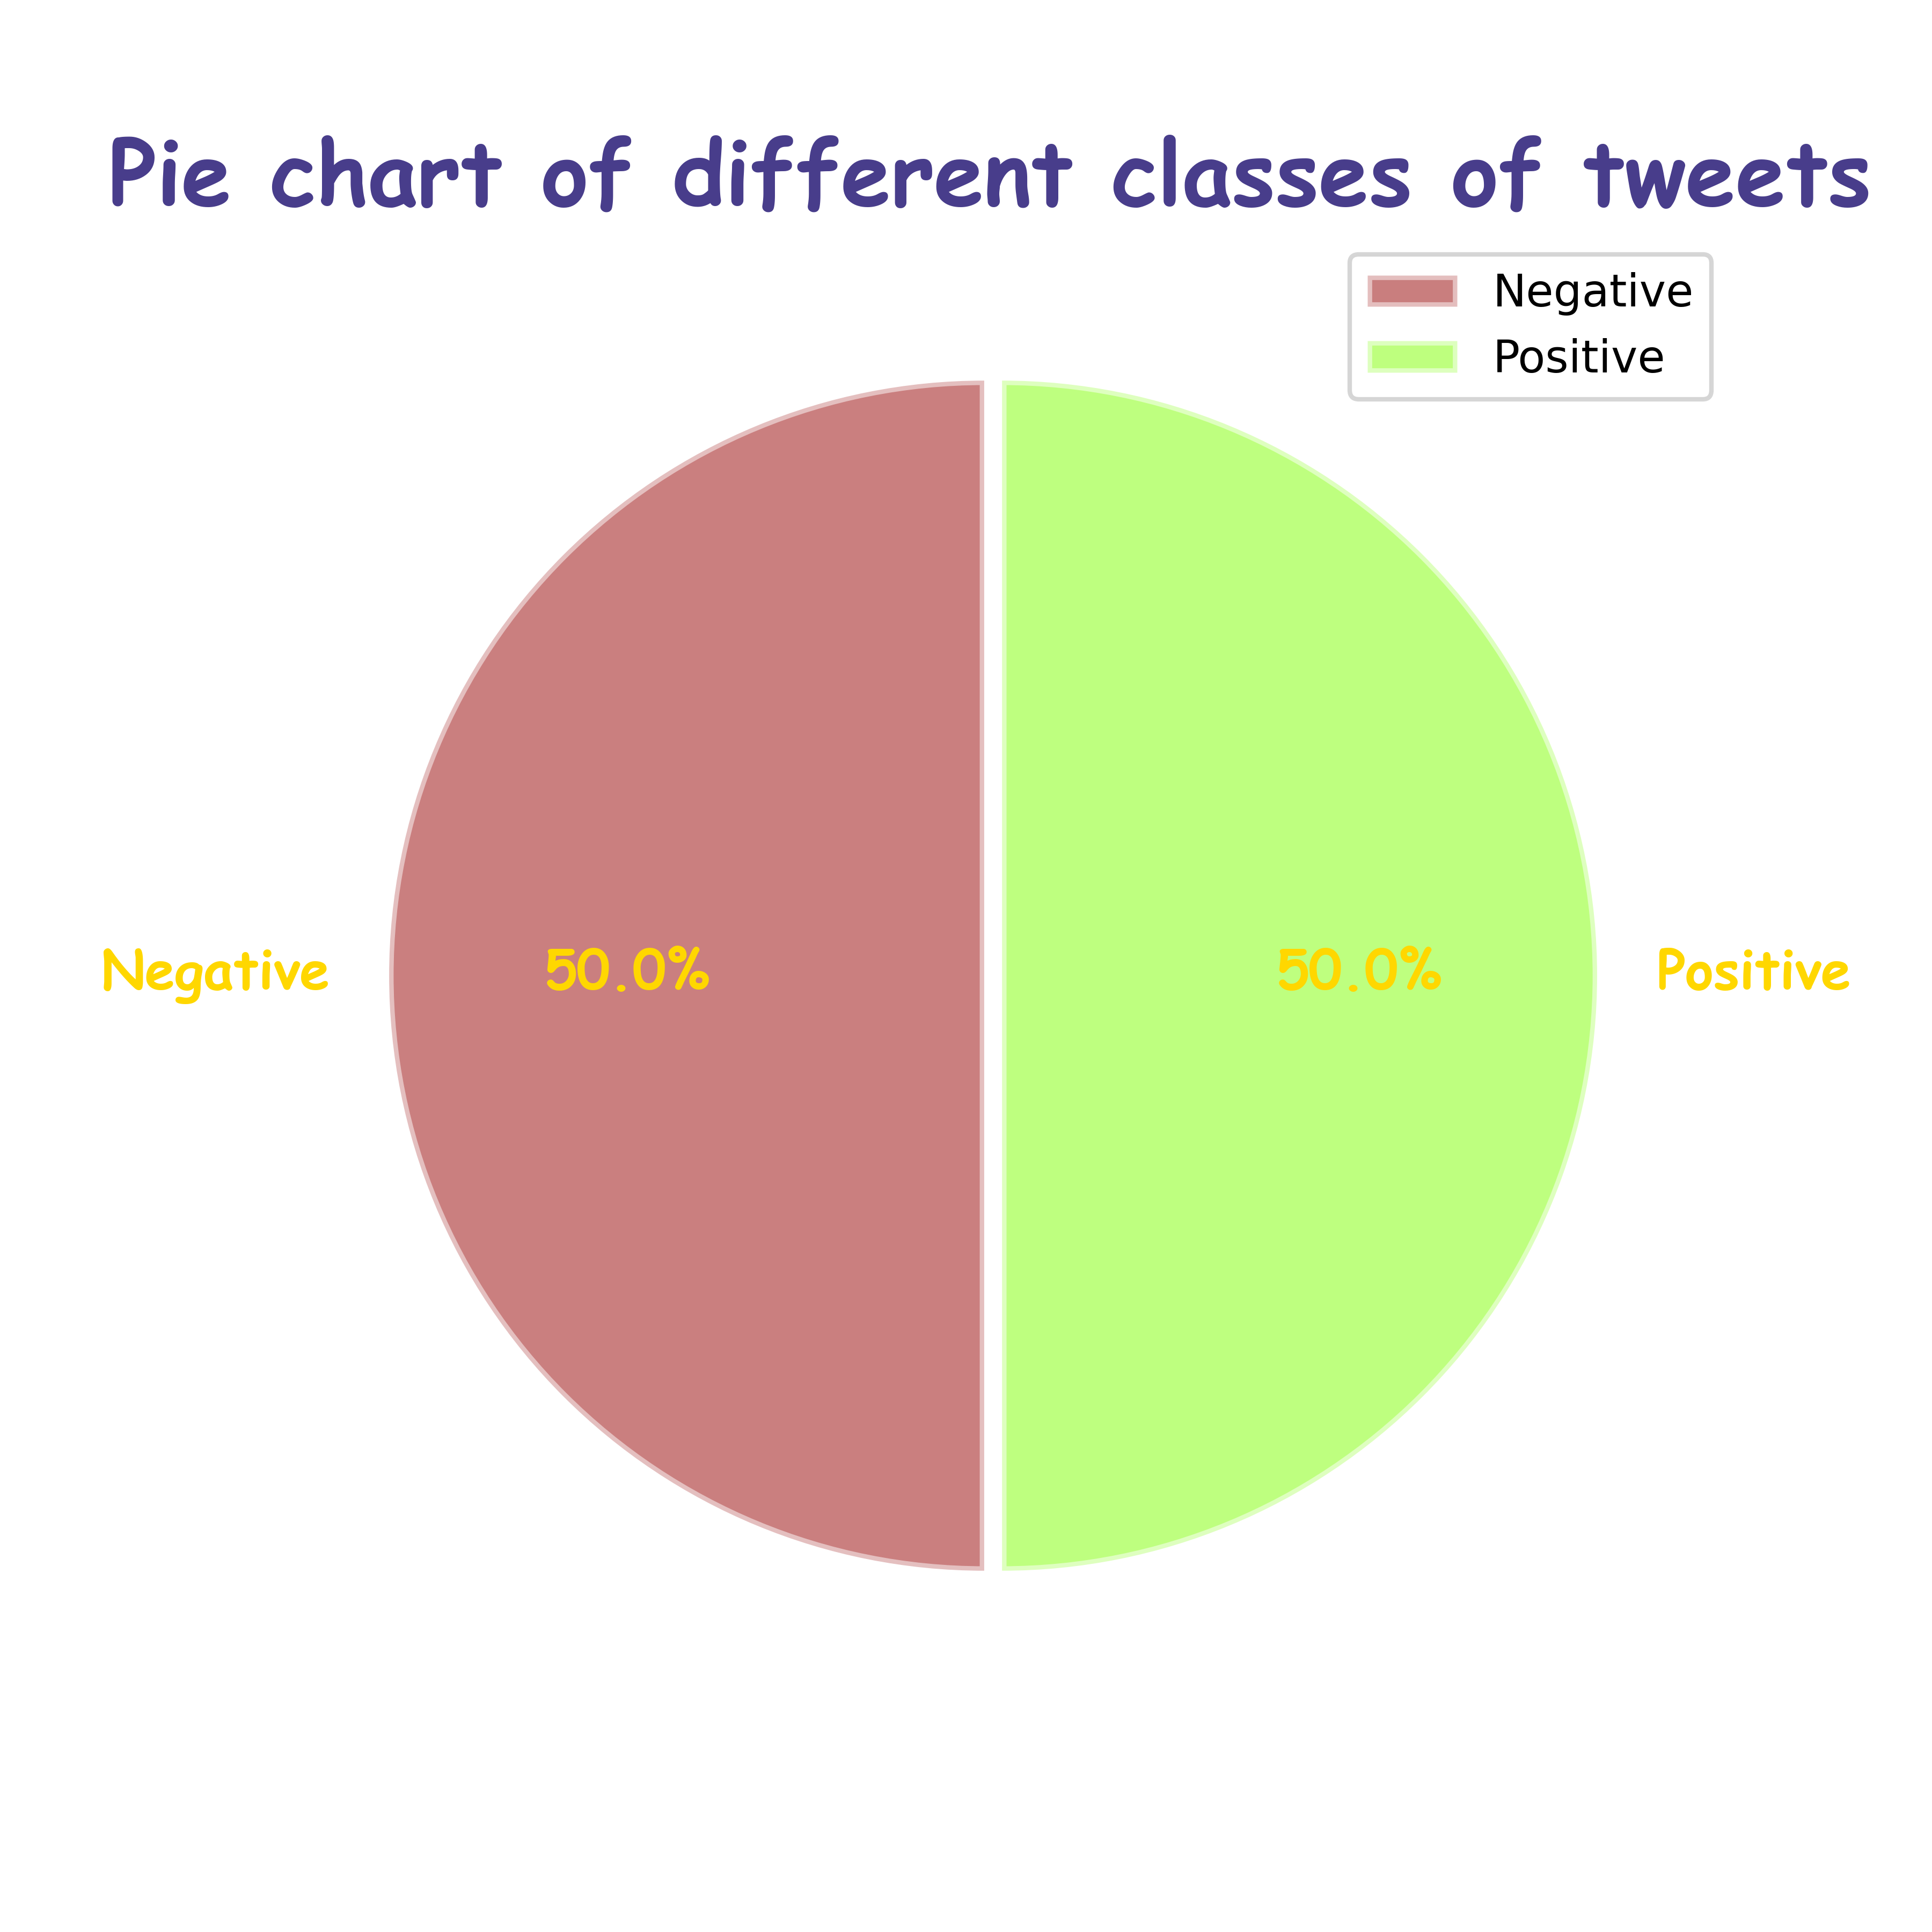

In [9]:
plt.figure(figsize=(6,6))

plt.pie(df.groupby('sentiment').size(),
        colors=['#960000','#7FFF00'], 
        labels=["Negative", "Positive"],
        wedgeprops = {'edgecolor': 'w', 'linewidth': 2, 'alpha':0.5},
        textprops = {'fontname': 'Comic Sans MS', 'fontsize': 12, 'fontweight': 'bold', 'color':'Gold'},
        explode = [0.01, 0.02], 
        startangle = 90,
        autopct = '%1.1f%%')

plt.title("Pie chart of different classes of tweets", 
          fontdict={'fontname' : 'Comic Sans MS', 'fontsize' : 20, 'fontweight': 'bold', 'color':'DarkSlateBlue'})
plt.ylabel("")
plt.legend()
plt.savefig(r"images\Pie chart of sentiments.png", transparent=True, dpi=600)
plt.close()

Image(r"images\Pie chart of sentiments.png", height=600, width=600)

* Equal distribution of sentiments in the dataset.

#### Analyzing the lengths of tweets

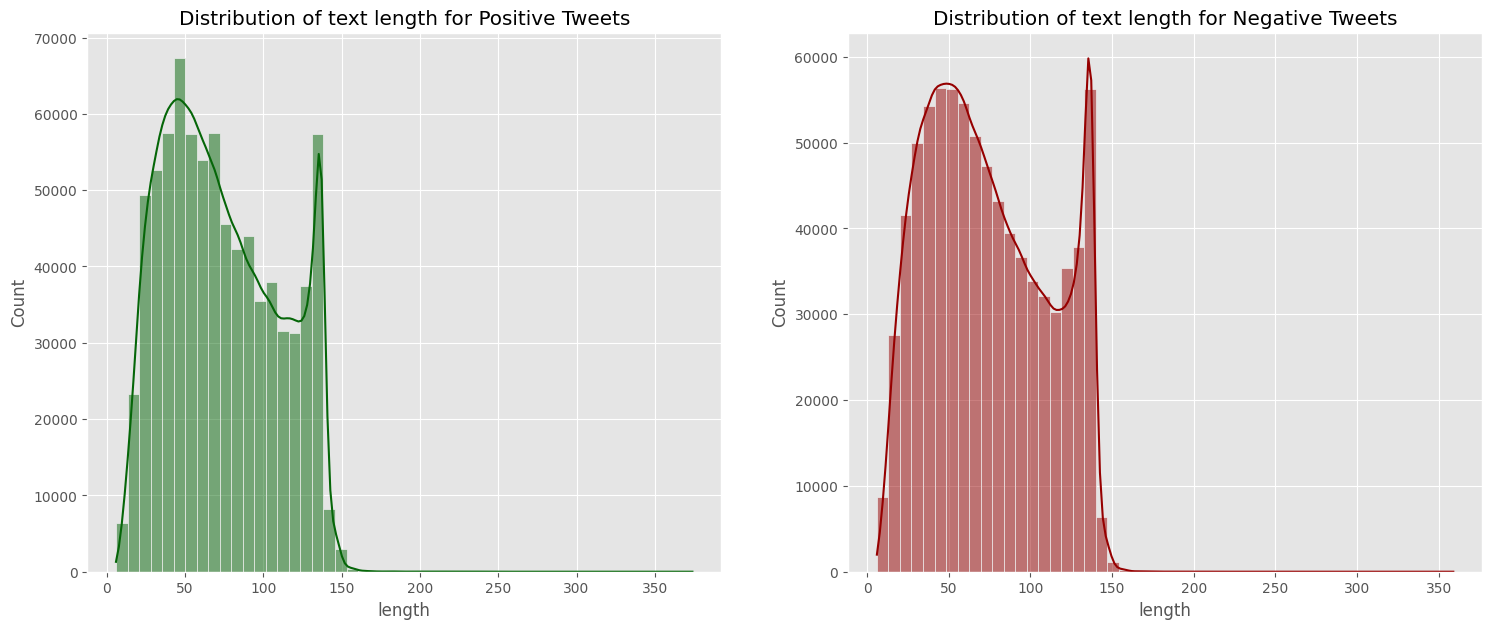

In [10]:
# Add a new column 'length' to df that contains the length of each tweet's text
df['length'] = df['text'].map(len)

# Filter the DataFrame to get only certain type of tweets
positive = df.loc[df["sentiment"] == "Positive"]
negative = df.loc[df["sentiment"] == "Negative"]

# Plot the distribution of text length with subplots
plt.style.use("ggplot")
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
axis.flatten()

sns.histplot(data=positive, x="length", bins=50, alpha=0.5, kde=True, color='#056608', ax=axis[0])
sns.histplot(data=negative, x="length", bins=50, alpha=0.5, kde=True, color='#960000', ax=axis[1])
axis[0].set_title("Distribution of text length for Positive Tweets")
axis[1].set_title("Distribution of text length for Negative Tweets")
plt.savefig(r"images\Text length distribution.png", dpi=600)
plt.show()

<a id="p5"></a>
<center><font color='PaleVioletRed' size='6'><i>Data Preprocessing</i></font></center>

Only `sentiment` and `text` columns are required for building the model, so I will discard the rest.

In [11]:
df.drop(columns =["ids", "date", "flag", "user", "length"], inplace=True)
df

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,Positive,Just woke up. Having no school is the best fee...
1599996,Positive,TheWDB.com - Very cool to hear old Walt interv...
1599997,Positive,Are you ready for your MoJo Makeover? Ask me f...
1599998,Positive,Happy 38th Birthday to my boo of alll time!!! ...


Changing the values of `sentiment` column

In [12]:
df["sentiment"] = df["sentiment"].map({"Negative": 0, "Positive": 1})
df

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


Lets have a look at the text data present here!

In [13]:
lines = list(df['text'].str.split(" "))

In [14]:
print(lines[0])
print(lines[1])

['@switchfoot', 'http://twitpic.com/2y1zl', '-', 'Awww,', "that's", 'a', 'bummer.', '', 'You', 'shoulda', 'got', 'David', 'Carr', 'of', 'Third', 'Day', 'to', 'do', 'it.', ';D']
['is', 'upset', 'that', 'he', "can't", 'update', 'his', 'Facebook', 'by', 'texting', 'it...', 'and', 'might', 'cry', 'as', 'a', 'result', '', 'School', 'today', 'also.', 'Blah!']


Glancing at some tweets, I can make the following assumptions:
- usernames present with a preceding @ symbol.
- emojis are written as a combination of signs.
- hyperlinks present 

### `Text Preprocessing Pipeline`

In [15]:
def nlp_preprocessor(corpora):
    """
    Preprocesses text data for NLP tasks.

    Args:
    - corpora (string/list/series/set): A collection of strings or a single string representing tweets.

    Returns:
    - processed_corpora (list): List of preprocessed text data.

    This function preprocesses text data by performing the following steps:
    1. Converts text to lowercase.
    2. Replaces URLs with 'url'.
    3. Replaces usernames with 'user'.
    4. Replaces non-alphanumeric characters with a space.
    5. Replaces sequences of 3 or more consecutive characters with 2 characters. (eg: "heyyyy" to "heyy")
    6. Replaces emojis with their meanings. (eg: :) = Happy face or smile, ;) = Wink or smirk)
    7. Removes stop-words. (eg: "the", "he", "have")
    7. Lemmatizes words. (e.g: “great” to “good”)
    
    Example:
    >>> corpora = "Text data to be preprocessed."
    >>> preprocessed_data = nlp_preprocessor(corpora)
    >>> preprocessed_data
    ['text data processed']
    
    Note:
    - Requires NLTK resources for stopwords and lemmatization.
    """

    # If tweets is a string or not an iterable type, convert it into a list with the string as its only item
    if isinstance(corpora, str) or not hasattr(corpora, '__iter__'):
        corpora = [corpora]

    # Start time for performance measurement
    start = time.time()
    
    # Initialize an empty list to store preprocessed text data
    processed_corpora = []

    # Set up NLTK resources
    english_stopwords = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Compile regex patterns for efficiency
    urlPattern = re.compile(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)")
    userPattern = re.compile(r'@[^\s]+')
    alphaPattern = re.compile(r"[^a-zA-Z0-9]")
    sequencePattern = re.compile(r"(.)\1\1+")
    
    # Iterate through each text in the corpora
    for row in corpora:
        # Convert text to lowercase
        row = row.lower()
        
        # Replace URLs with 'url'
        row = re.sub(urlPattern, ' url', row)
        
        # Replace usernames with 'user'
        row = re.sub(userPattern, ' user', row)
        
        # Replace non-alphanumeric characters with a space
        row = re.sub(alphaPattern, " ", row)
        
        # Replace sequences of 3 or more consecutive characters with 2 characters
        row = re.sub(sequencePattern, r"\1\1", row)
        
        # Replace emojis with their meanings
        for emoticon, description in EMOTICONS_EMO.items():
            row = row.replace(emoticon, description.lower())

        # Lemmatize words and remove stopwords using list comprehension
        row = " ".join([lemmatizer.lemmatize(word) for word in row.split() if word not in english_stopwords])
        
        # Append preprocessed text to the list
        processed_corpora.append(row)

    # End time for performance measurement
    end = time.time()
    
    # Print processing completion message and time taken
    print(f'Text Preprocessing complete.')
    print(f'Time Taken: {round(end - start)} seconds')

    # Return the preprocessed text data
    return processed_corpora

In [16]:
help(nlp_preprocessor)

Help on function nlp_preprocessor in module __main__:

nlp_preprocessor(corpora)
    Preprocesses text data for NLP tasks.

    Args:
    - corpora (string/list/series/set): A collection of strings or a single string representing tweets.

    Returns:
    - processed_corpora (list): List of preprocessed text data.

    This function preprocesses text data by performing the following steps:
    1. Converts text to lowercase.
    2. Replaces URLs with 'url'.
    3. Replaces usernames with 'user'.
    4. Replaces non-alphanumeric characters with a space.
    5. Replaces sequences of 3 or more consecutive characters with 2 characters. (eg: "heyyyy" to "heyy")
    6. Replaces emojis with their meanings. (eg: :) = Happy face or smile, ;) = Wink or smirk)
    7. Removes stop-words. (eg: "the", "he", "have")
    7. Lemmatizes words. (e.g: “great” to “good”)

    Example:
    >>> corpora = "Text data to be preprocessed."
    >>> preprocessed_data = nlp_preprocessor(corpora)
    >>> preprocessed

In [17]:
df['text'] = nlp_preprocessor(df['text'])

df

Text Preprocessing complete.
Time Taken: 60 seconds


,sentiment,text
0,0,user url aww bummer shoulda got david carr thi...
1,0,upset update facebook texting might cry result...
2,0,user dived many time ball managed save 50 rest...
3,0,whole body feel itchy like fire
4,0,user behaving mad see
...,...,...
1599995,1,woke school best feeling ever
1599996,1,thewdb com cool hear old walt interview url
1599997,1,ready mojo makeover ask detail
1599998,1,happy 38th birthday boo time tupac amaru shakur


<a id="p6"></a>
<center><font color='PaleVioletRed' size='6' font-family:'verdana'><i>Word Cloud</i></font></center>

A word cloud is a visual representation of text data where words from the text are displayed in varying sizes according to their frequency of occurrence. Typically, the more frequently a word appears in the text, the larger and more prominent it appears in the word cloud. Word clouds are often used to quickly and visually summarize the most significant terms within a body of text, making them useful for identifying key themes, topics, or trends.

Read the documentation [here](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html)!

In [18]:
# Filter positive and negative tweets based on sentiment
positive_tweets = df.loc[df["sentiment"] == 1]["text"]
negative_tweets = df.loc[df["sentiment"] == 0]["text"]

# Create WordCloud objects for positive and negative tweets
wc_pos = WordCloud(max_words=500, 
                   width=1280, 
                   height=920,
                   collocations=False).generate((" ").join(positive_tweets))

wc_neg = WordCloud(max_words=500, 
                   width=1280, 
                   height=920,
                   collocations=False).generate((" ").join(negative_tweets))

# Plot using subplots
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
axis.flatten()

axis[0].imshow(wc_pos)
axis[1].imshow(wc_neg)
axis[0].set_title("Positive Tweets", fontdict={'fontname':'Comic Sans MS', 'fontsize':32, "color":"#7FFF00"})
axis[1].set_title("Negative Tweets", fontdict={'fontname':'Comic Sans MS', 'fontsize':32, "color":"#960000"})
axis[0].axis('off')
axis[1].axis('off')
plt.savefig(r"images\Word cloud.png", transparent=True, dpi=600)
plt.tight_layout()
plt.close()

Image(r"images\Word cloud.png", height=920, width=1280)

<a id="p7"></a>
<center><font color='PaleVioletRed' size='6'><i></i>Splitting the Data</font></center>

Dividing processed data into 2 sets: 
* **Training Data:** The dataset upon which the model would be trained on. Contains 80% data.
* **Test Data:** The dataset upon which the model would be tested against. Contains 20% data.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size = 0.2, random_state = 42)

<a id="p8"></a>
<center><font color='PaleVioletRed' size='6'><i>TF-IDF Vectoriser</i></font></center>

TF-IDF, which stands for Term Frequency-Inverse Document Frequency, is a technique used in natural language processing and information retrieval to represent the importance of a word in a document relative to a collection of documents, known as a corpus. It calculates a numerical value for each word based on how frequently it appears in the document (`term frequency`) and how rare it is across all documents in the corpus (`inverse document frequency`). This approach helps in identifying the significance of words in individual documents and the broader context of the entire corpus, thus enabling more informative text representation for various tasks such as document classification and information retrieval.

- *Term frequency (Tf)* gives a measure of a frequency of a word in a document. <br>
For our example, in document "Cat loves to play with a ball." tf('cat') = 1/6 (note: word 'a' has been ignored as discussed previously.)

- *Inverse document frequency (idf)* is a measure of the importance of the word across all the document in the corpus. <br>
The idea is to identify how common or rare a word is. For example, a few words such as 'is' or 'and' are very common and most likely, they will be present in almost every document. Let's say a word 'is' is present in all the documents in a corpus of 1000 documents. Then idf('is') = log (1000/1000) = log 1 = 0

- *tf-idf* is a multiplication of tf and idf values.

<center><img src="https://ptime.s3.ap-northeast-1.amazonaws.com/media/natural_language_processing/text_feature_Engineering/tf-idf-formula.PNG"></center>

Read the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)!

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train)

pickle.dump(vectorizer, open(r'models\TfidfVectorizer(ngram_range_1-2).pkl','wb'))

ngram_range parameter takes two values: min_n and max_n.
For example:
- ngram_range=(1, 1) means that only unigrams (single words) will be considered.
- ngram_range=(1, 2) means that both unigrams and bigrams (sequences of two words) will be considered.
- ngram_range=(2, 2) means that only bigrams will be considered.

In [21]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [22]:
X_train.shape

(1280000, 3451677)

* The first dimension of the shape, 1280000, represents the number of samples or instances in training dataset. This indicates that you have 1,280,000 individual training examples.
* The second dimension of the shape, 3451677, represents the number of features or attributes per sample. Each training example is described by 3,451,677 features.

In [23]:
X_train

<1280000x3451677 sparse matrix of type '<class 'numpy.float64'>'
	with 17548656 stored elements in Compressed Sparse Row format>

<a id="p9"></a>
<center><font color='PaleVioletRed' size='6'><i>Creating and Evaluating Models</i></font></center>

### Model Evaluation Function

In [24]:
def classification_metrics(model):
    y_pred = model.predict(X_test)

    # Print classification report
    print(classification_report(y_test, y_pred))
    
    # Plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    group_names = ['TN', 'FP', 'FN','TP']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.style.use("grayscale")
    sns.heatmap(cf_matrix, 
                annot = labels,
                cmap = 'YlOrBr',
                fmt = '',
                xticklabels = ['Negative','Positive'],
                yticklabels = ['Negative','Positive'])
    
    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.title ("Confusion Matrix")
    plt.show()

<a id="p9-1"></a>
<font color='DeepSkyBlue' size='5'><i>Logistic Regression</i></font>

A simple yet effective algorithm for binary classification tasks. It works well with sparse and high-dimensional data, making it suitable for text classification tasks.

              precision    recall  f1-score   support

           0       0.80      0.78      0.79    159494
           1       0.78      0.81      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



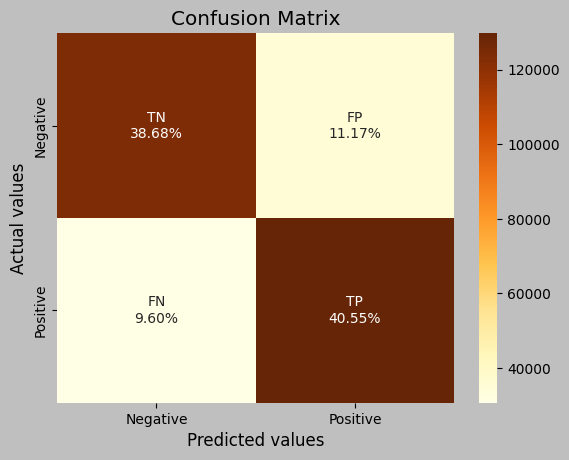

In [25]:
LRmodel = LogisticRegression()
LRmodel.fit(X_train, y_train)

pickle.dump(LRmodel, open(r'.\models\Logistic Regression Model.pkl','wb'))

classification_metrics(LRmodel)

<a id="p9-2"></a>
<font color='DeepSkyBlue' size='5'><i>BernoulliNB Model</i></font>

Despite its simplicity, Naive Bayes performs surprisingly well for text classification tasks. It's particularly suitable for sentiment analysis and spam filtering applications.

              precision    recall  f1-score   support

           0       0.79      0.77      0.78    159494
           1       0.78      0.79      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



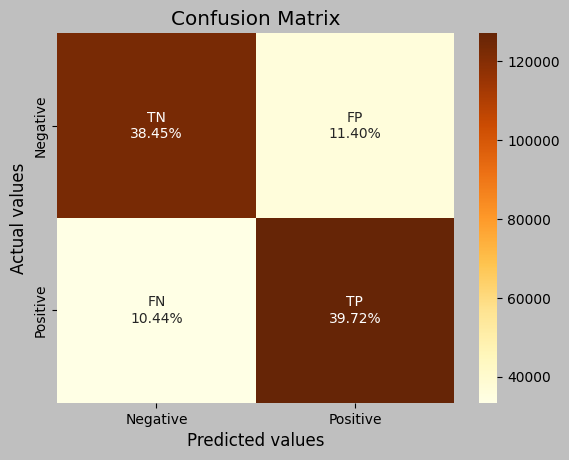

In [26]:
NBmodel = BernoulliNB()
NBmodel.fit(X_train, y_train)

pickle.dump(NBmodel, open(r'.\models\Bernoulli Naive Bayes Model.pkl','wb'))

classification_metrics(NBmodel)

<a id="p9-3"></a>
<font color='DeepSkyBlue' size='5'><i>LinearSVC Model</i></font>

SVMs are powerful for both classification and regression tasks. They work well in high-dimensional spaces and are effective for binary classification tasks, especially when there is a clear margin of separation between classes.

              precision    recall  f1-score   support

           0       0.79      0.78      0.78    159494
           1       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



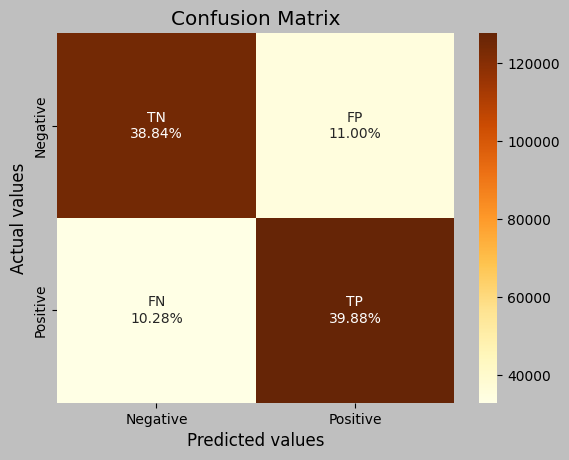

In [27]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

pickle.dump(SVCmodel, open(r'.\models\Linear SVC Model.pkl','wb'))

classification_metrics(SVCmodel)

Since the dataset is perfectly balanced, I will consider using accuracy as the performance metric to compare the models. 
* Logistic Regression - 0.79
* Bernoulli Naive Bayes - 0.78
* Linear SVC - 0.79

I will use Logistic Regression to test out some of my custom tweets.

<a id="p10"></a>
<center><font color='PaleVioletRed' size='6'><i>Test on custom tweets</i></font></center>

In [28]:
from IPython.display import display, HTML

def detect_sentiment(tweets, preprocessor, model, vectorizer):
    """
    Detects sentiment of tweets using a given model and vectorizer.

    Args:
        tweets: A collection of strings in form of list/series/set or a single string representing tweets.
        preprocessor: A function used to preprocess the tweets before sentiment analysis.
        model: The trained sentiment analysis model.
        vectorizer: The vectorizer used to transform the tweets into a format suitable for the model.

    Returns:
        None

    Displays the sentiment of each tweet along with its text and an accompanying image.

    Example:
        >>> tweets = ["I love this movie!", "This is the worst product ever!"]
        >>> # Assuming you have your model and vectorizer defined somewhere
        >>> model = ...
        >>> vectorizer = ...
        >>> detect_sentiment(tweets, preprocessor, model, vectorizer)
    """

    # If tweets is a string or not an iterable type, convert it into a list with the string as its only item
    if isinstance(tweets, str) or not hasattr(tweets, '__iter__'):
        tweets = [tweets]

    # GIF URLs
    positive_gif_url = 'https://media4.giphy.com/media/v1.Y2lkPTc5MGI3NjExOXA1Z294dWNrNTVwOGkzYmM2dWZlM2t4MnQ5MnZqYW4zdHlkNjh3eiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9cw/B278fjCLIP6CcwvHPV/giphy.gif'
    negative_gif_url = 'https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExYWp1cDM5dTl0YW5hbGdudHd5eWtucHh5ajBkZzAzdTh0NTVwZWp1cyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9cw/47Bla0Yuh0uGlMam9R/giphy.gif'
    twitter_logo = 'https://upload.wikimedia.org/wikipedia/commons/6/6f/Logo_of_Twitter.svg'

    # Empty list to store result
    y_pred = []

    # Preprocess the tweets
    processed_tweets = preprocessor(tweets)

    # Vectorize tweets
    vectorized_tweets = vectorizer.transform(processed_tweets)

    # Predict sentiment
    y_pred = model.predict(vectorized_tweets)

    for tweet, sentiment in zip(tweets, y_pred):
        # Display a formatted version of the tweet
        formatted_tweet = f'<img src="{twitter_logo}" height="25" width="25" alt="Twitter Logo"> <span style="font-size: 21px; color: DeepSkyBlue; font-family: verdana;">{tweet}</span>'
        display(HTML(formatted_tweet))

        # Display a gif based on the sentiment
        if sentiment == 1:
            gif_html = f'<img src="{positive_gif_url}" width="250px" height="250px" alt="Positive Sentiment GIF">'
        else:
            gif_html = f'<img src="{negative_gif_url}" width="250px" height="250px" alt="Negative Sentiment GIF">'
        
        display(HTML(gif_html))

In [29]:
help(detect_sentiment)

Help on function detect_sentiment in module __main__:

detect_sentiment(tweets, preprocessor, model, vectorizer)
    Detects sentiment of tweets using a given model and vectorizer.

    Args:
        tweets: A collection of strings in form of list/series/set or a single string representing tweets.
        preprocessor: A function used to preprocess the tweets before sentiment analysis.
        model: The trained sentiment analysis model.
        vectorizer: The vectorizer used to transform the tweets into a format suitable for the model.

    Returns:
        None

    Displays the sentiment of each tweet along with its text and an accompanying image.

    Example:
        >>> tweets = ["I love this movie!", "This is the worst product ever!"]
        >>> # Assuming you have your model and vectorizer defined somewhere
        >>> model = ...
        >>> vectorizer = ...
        >>> detect_sentiment(tweets, preprocessor, model, vectorizer)



In [30]:
if __name__ == '__main__':
    # Example tweets
    tweets = [
        "What a beautiful day to start something new!",
        "Just finished my workout, feeling amazing!",
        "Really disappointed with the customer service I received.",
    ]


    # Load the logistic regression model and the vectorizer
    model = pickle.load(open(r"models/Logistic Regression Model.pkl", "rb"))
    vectorizer = pickle.load(open(r"models/TfidfVectorizer(ngram_range_1-2).pkl", "rb"))


    # Display Result
    detect_sentiment(tweets, preprocessor=nlp_preprocessor, model=model, vectorizer=vectorizer)

Text Preprocessing complete.
Time Taken: 0 seconds


***Inference:*** While our sentiment analysis model strives for accuracy, it's essential to acknowledge that it may not always achieve 100% precision. Like any predictive system, there are instances where the model might misclassify or inaccurately predict sentiment. This could occur due to various factors, such as ambiguous language, sarcasm, or the presence of uncommon expressions or context that the model hasn't encountered during training. Additionally, sentiment analysis is inherently subjective, and interpretations of sentiment can vary among individuals. Therefore, it's crucial to interpret the model's predictions with a degree of caution and to conduct error analysis to understand the reasons behind incorrect classifications. By identifying patterns in misclassifications, we can iteratively refine and improve the model's performance, ultimately enhancing its accuracy and reliability over time.